# Basic LSTM implementation in PyTorch

## Sequence prediction of a Sine Wave

- Training a simple LSTM to predict the next value from the values of a sequence of Sine wave, LSTM works here by remembering the past trends of input and using that trneds to predict the next value in the sequence
-  Example: Given `[0.0, 0.84, 0.91, 0.14]` (sine wave values), predict the next value `-0.76`
- Input: A sequence of past values (e.g., last 50 time steps)
    - Output: The next value(s) in the sequence
    - Think of it like: "Given the last 50 points of a sine wave, predict the next point"
 ### Regular neural networks forget the past. LSTMs have a memory cell that:
  - Forget Gate: Decides what to forget from previous time steps
  - Input Gate: Decides what new info to store
  - Output Gate: Decides what to output based on memory

In [7]:
# step1 - generating the data

import numpy as np
import torch

x=np.linspace(0, 100, 1000)  # divide the interval between 0 and 100 into 1000 equal parts
data=np.sin(x)               # here np.sin() expects radians

# creatiing the sequence, input seq -> target sequence
def create_seq(data, seq_len):
    xs, ys=[], []   # creating multiple inp, target sequences from a single dataset
    for i in range(len(data)-seq_len):
        x=data[i:i+seq_len]   # seq of values
        y=data[i+seq_len]   #next single value
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

x, y = create_seq(data, 50)
# print(len(x), y)

### LSTM Architecture

In [8]:
import torch.nn as nn

class LSTMPredictor(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, output_size=1):           # input size is the number of values we pass at each time instant,  # hidden_size is the size of our hidden state, # num_layers is the num of LSTMs stacked up, output_size is the no of values to predict    
                                                                                        
        super().__init__()
        self.hidden_size=hidden_size
        self.num_layers=num_layers

        #lstm layer
        self.lstm=nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        #fc layer to get the output
        self.fc=nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x is our input, shape: (batch_size, seq_len, input_size)
        lstm_out, _ =self.lstm(x)     # lstm output is h_t( hidden state ) lstm_out shape: (32, 50, hidden_size=64)
                                      # This is h_1, h_2, ..., h_50 for each sample
        lstm_last_out = lstm_out[:, -1, :]     # extract only h_50 ( 32, 64)
        prediction = self.fc(lstm_last_out)    # we make pred, y= w.h_50 + b
        return prediction
                                                                                            

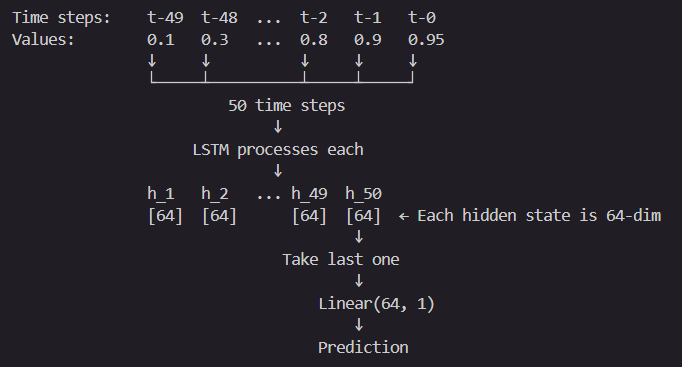

In [9]:
x=torch.FloatTensor(x).unsqueeze(-1)
y=torch.FloatTensor(y).unsqueeze(-1)

In [10]:
model = LSTMPredictor()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs =100

for epoch in range(epochs):
    prediction=model(x)
    loss=criterion(prediction, y)

    #backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if(epoch%10==0): print("Loss=", loss)

Loss= tensor(0.4776, grad_fn=<MseLossBackward0>)
Loss= tensor(0.0513, grad_fn=<MseLossBackward0>)
Loss= tensor(0.0184, grad_fn=<MseLossBackward0>)
Loss= tensor(0.0003, grad_fn=<MseLossBackward0>)
Loss= tensor(0.0021, grad_fn=<MseLossBackward0>)
Loss= tensor(5.7841e-05, grad_fn=<MseLossBackward0>)
Loss= tensor(0.0003, grad_fn=<MseLossBackward0>)
Loss= tensor(2.1219e-05, grad_fn=<MseLossBackward0>)
Loss= tensor(4.3248e-05, grad_fn=<MseLossBackward0>)
Loss= tensor(2.4276e-05, grad_fn=<MseLossBackward0>)


## Testing our model

In [29]:
# lets generate new data
x_test=np.linspace(0, 50, 500)
x_data=np.sin(x_test)
test_x, test_y=create_seq(x_data, 16)
test_x=torch.FloatTensor(test_x).unsqueeze(-1)
test_y=torch.FloatTensor(test_y).unsqueeze(-1)


model.eval()
with torch.no_grad():
    predictions=model(test_x).numpy()
    print("Loss=", loss.item())
    
print(dict(zip(predictions.flatten().tolist(), test_y)))
test_x.shape

Loss= 1.3688995750271715e-05
{1.0135498046875: tensor([0.9995]), 1.004969596862793: tensor([0.9912]), 0.9873668551445007: tensor([0.9730]), 0.9606882929801941: tensor([0.9451]), 0.9249332547187805: tensor([0.9076]), 0.8801819682121277: tensor([0.8611]), 0.8266213536262512: tensor([0.8059]), 0.7645636200904846: tensor([0.7426]), 0.6944571137428284: tensor([0.6719]), 0.616888701915741: tensor([0.5945]), 0.532576858997345: tensor([0.5110]), 0.44235602021217346: tensor([0.4225]), 0.347154438495636: tensor([0.3297]), 0.2479695975780487: tensor([0.2336]), 0.1458461582660675: tensor([0.1352]), 0.041862912476062775: tensor([0.0354]), -0.06287198513746262: tensor([-0.0648]), -0.16721822321414948: tensor([-0.1643]), -0.27000001072883606: tensor([-0.2621]), -0.37001141905784607: tensor([-0.3573]), -0.466035932302475: tensor([-0.4490]), -0.5568826198577881: tensor([-0.5361]), -0.6414344906806946: tensor([-0.6179]), -0.7186986804008484: tensor([-0.6934]), -0.7878488898277283: tensor([-0.7620]), -0.

torch.Size([484, 16, 1])

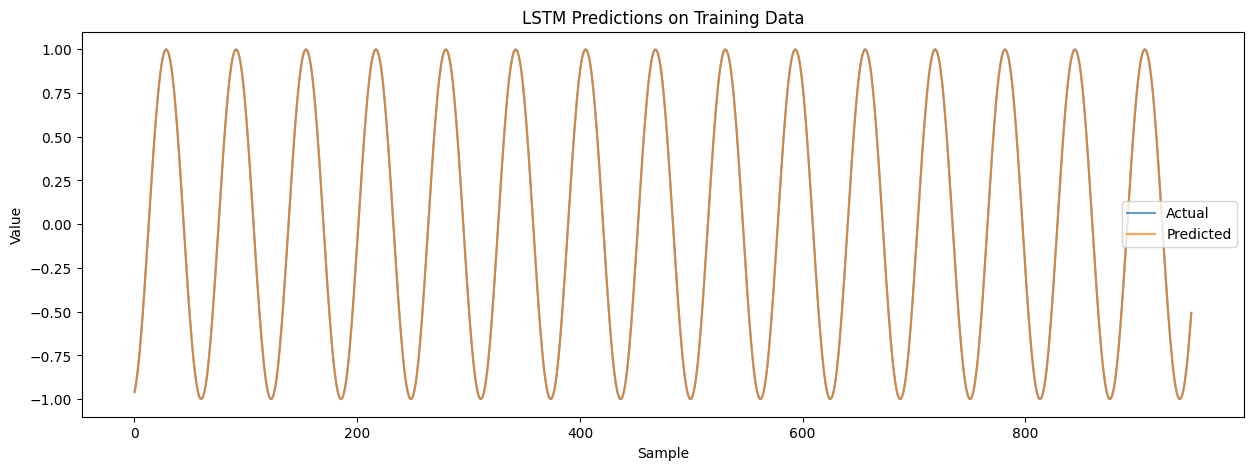


Sample predictions:
Actual: -0.9575, Predicted: -0.9609, Error: 0.003439
Actual: -0.9239, Predicted: -0.9287, Error: 0.004804
Actual: -0.8810, Predicted: -0.8867, Error: 0.005728
Actual: -0.8293, Predicted: -0.8354, Error: 0.006109
Actual: -0.7693, Predicted: -0.7752, Error: 0.005898


In [16]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    predictions = model(x).numpy()

       # Plot actual vs predicted
    plt.figure(figsize=(15, 5))
    plt.plot(y.numpy(), label='Actual', alpha=0.7)
    plt.plot(predictions, label='Predicted', alpha=0.7)
    plt.legend()
    plt.title('LSTM Predictions on Training Data')
    plt.xlabel('Sample')
    plt.ylabel('Value')
    plt.show()

       # Print some example predictions
    print("\nSample predictions:")
    for i in range(5):
           print(f"Actual: {y[i].item():.4f}, Predicted: {predictions[i].item():.4f}, Error: {abs(y[i].item() - predictions[i].item()):.6f}")